In [ ]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

Dataset: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant#  contains 9568 data 
points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was 
set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient 
Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy 
output (EP) of the plant.

Download the datset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip

# unzip data
!unzip CCPP.zip

--2021-09-04 15:02:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674852 (3.5M) [application/x-httpd-php]
Saving to: ‘CCPP.zip’

CCPP.zip            100%[===================>]   3.50M  6.11MB/s    in 0.6s    

2021-09-04 15:02:36 (6.11 MB/s) - ‘CCPP.zip’ saved [3674852/3674852]

Archive:  CCPP.zip
   creating: CCPP/
  inflating: CCPP/Folds5x2_pp.ods    
  inflating: CCPP/Folds5x2_pp.xlsx   
  inflating: CCPP/Readme.txt         
  inflating: CCPP/Readme.txt~        


In [ ]:
# read dataset into pandas dataframe
df = pd.read_excel('/content/CCPP/Folds5x2_pp.xlsx') 
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Question : Fit a linear regression model to predict/estimate the EP of the plant based on T, AP, RH, V and 
EP.  Write  the  equation  in  terms  of  the  variables,  including  the  bias  term.  You  must  use  the  normal 
equations method for this part.

AT, V, AP, RH are the input variables (X) to our regression model and PE (EP) is the target variable (y)

In [ ]:
# converting X to a numpy array

df['bias'] = 1  # add a column of ones to X. this corresponds to the bias term
X = df.drop(['PE'], axis=1).to_numpy()

# converting y to a numpy array
y = df['PE'].to_numpy()

Let $\theta$ be the parameters of the linear regression model. We define the loss function to be the least squares error : $J(\theta) = \frac{1}{2}\sum_{i=1}^{i=m}(h_{\theta}(x^{(i)})-y^{(i)})^{2} = \frac{1}{2}(X\theta - y)^{T}(X\theta - y)$, where $h_{\theta}(x)$ is the hypothesis function given by $x^{T}\theta$. Superscript $i$ denotes the $i$th example. The gradient of $J$ with respect to the parameters turn out to be : $\Delta_{\theta}J(\theta) = X^{T}X\theta - X^{T}y$. Setting the derivatives to zero we obtain the normal equations : $X^{T}X\theta = X^{T}y$. Therefore, $\theta = (X^{T}X)^{-1}X^{T}y$.

In [ ]:
# computing theta using the normal equations

start_time = time.time()
theta = np.linalg.inv(X.T@X)@X.T@y
print(theta)
print("Time taken to obtain solution : %s seconds" % (time.time() - start_time))

[-1.97751311e+00 -2.33916423e-01  6.20829438e-02 -1.58054103e-01
  4.54609274e+02]
Time taken to obtain solution : 0.0039370059967041016 seconds


Question : Compute the least squares error of your solution. Find 5 data points with highest error. Are they 
outliers  in  the  dataset?  Compare  the  values  of  their  attributes  with  the  range  of  the  attribute,  (i.  e. 
comment if they lie near the surface of the data hyper-space)? 

In [ ]:
# computing least squares error of solution
J = 0.5*(X@theta - y).T@(X@theta - y)

# hypothesis function for a single data point
def h_theta(x, theta):
  return x.T@theta

errors = [] # to store errors for data points

for i in range(X.shape[0]):
  errors.append((h_theta(X[i], theta) - y[i])**2)  # calculate errors for all data points

indices = np.argsort(errors)
top5 = indices[len(indices)-5:] # last 5 indices correspond to the points with the highest error (since argsort)

In [ ]:
print('Least Squares Error :', J)

Least Squares Error : 9.695373823508004e+28


We visualize the points with the highest error with PCA

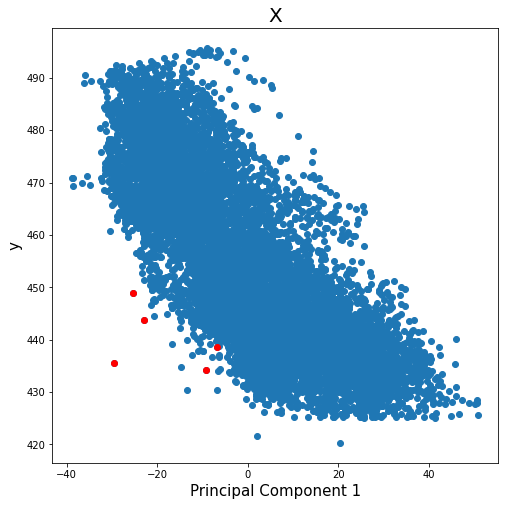

In [ ]:
# applying PCA with 1 principal component
pca = PCA(n_components=1)
pcompsX = pca.fit_transform(X)

# plotting
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('y', fontsize = 15)
ax.set_title('X', fontsize = 20)
ax.scatter(pcompsX[:, 0], y)

for idx in top5:
  ax.scatter(pcompsX[idx], y[idx], color="red")

The points highlighted in red in the PCA plot correspond to the highest errors

Question : Repeat the analysis with Pseudo-inverse (using Randomized SVD method) and QR factorization 
method

Using Pseudo-inverse :

In [ ]:
start_time = time.time()
U, Sigma, VT = randomized_svd(X, 
                              n_components=4,
                              random_state=None)

V = VT.T
theta_svd = V@np.diag(Sigma)@U.T@y
print(theta_svd)
print("Time taken to obtain solution : %s seconds" % (time.time() - start_time))

[8.42773431e+07 2.34282373e+08 4.40550917e+09 3.19630083e+08
 4.34726501e+06]
Time taken to obtain solution : 0.010572671890258789 seconds


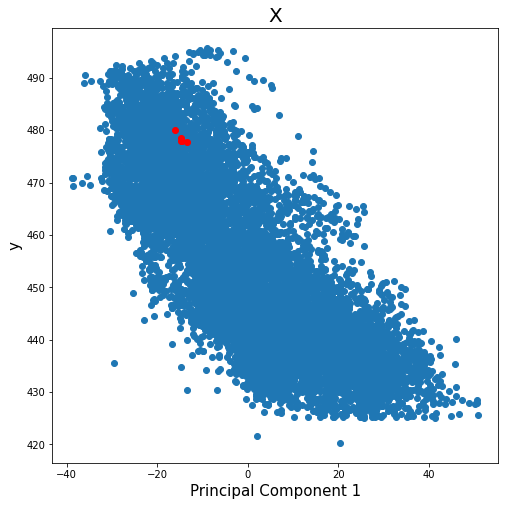

In [ ]:
# computing least squares error of solution
J = 0.5*(X@theta_svd - y).T@(X@theta_svd - y)

errors = [] # to store errors for data points

for i in range(X.shape[0]):
  errors.append((h_theta(X[i], theta_svd) - y[i])**2)  # calculate errors for all data points

indices = np.argsort(errors)
top5 = indices[len(indices)-5:] # last 5 indices correspond to the points with the highest error (since argsort)

# applying PCA with 1 principal component
pca = PCA(n_components=1)
pcompsX = pca.fit_transform(X)

# plotting
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('y', fontsize = 15)
ax.set_title('X', fontsize = 20)
ax.scatter(pcompsX[:, 0], y)

for idx in top5:
  ax.scatter(pcompsX[idx], y[idx], color="red")

In [ ]:
print('Least Squares Error :', J)

Least Squares Error : 9.695392548737581e+28


Using QR factorization :

In [ ]:
start_time = time.time()
q, r = np.linalg.qr(X)

theta_qr = np.linalg.inv(r)@q.T@y
print(theta_qr)
print("Time taken to obtain solution : %s seconds" % (time.time() - start_time))

[-1.97751311e+00 -2.33916423e-01  6.20829438e-02 -1.58054103e-01
  4.54609274e+02]
Time taken to obtain solution : 0.0059201717376708984 seconds


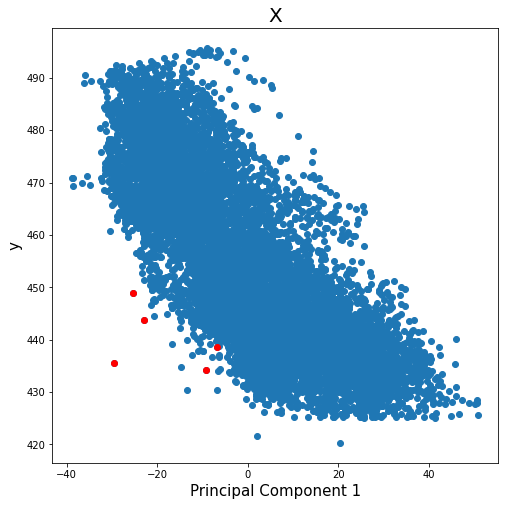

In [ ]:
# computing least squares error of solution
J = 0.5*(X@theta_qr - y).T@(X@theta_qr - y)

errors = [] # to store errors for data points

for i in range(X.shape[0]):
  errors.append((h_theta(X[i], theta_qr) - y[i])**2)  # calculate errors for all data points

indices = np.argsort(errors)
top5 = indices[len(indices)-5:] # last 5 indices correspond to the points with the highest error (since argsort)

# applying PCA with 1 principal component
pca = PCA(n_components=1)
pcompsX = pca.fit_transform(X)

# plotting
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('y', fontsize = 15)
ax.set_title('X', fontsize = 20)
ax.scatter(pcompsX[:, 0], y)

for idx in top5:
  ax.scatter(pcompsX[idx], y[idx], color="red")